# Exploration of Chicago Rideshare Dataset
* Import
* Wrangling
* Viz
* Modelling

## Import

In [2]:
%config IPCompleter.greedy=True

In [3]:
import csv
import os
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import geopandas as gpd
import seaborn as sns
import contextily as ctx #for basemaps

In [ ]:
%%time
#Get data - either sample 12 GB file or load pre-sampled data
datadir=r'/Users/rtaylor/Desktop/Springboard/DataSets/Rideshare'
firstrun=True#False #set to true to reimport dataset from csv
if firstrun:
    iterdf=pd.read_csv(os.path.join(datadir,'Transportation_Network_Providers_-_Trips.csv'),chunksize=200000)
    #dataset has 40 million records
    samp_df=pd.DataFrame()
    #sample 5% of df and make new df
    for chunk in iterdf:
        samp_df=samp_df.append(chunk.sample(frac=0.05)) #5% of rides
    samp_df=samp_df.dropna(how='any')
    samp_df.columns = ['TripID', 'TripStart', 'TripEnd', 'TripSeconds',
           'TripMiles', 'PUCensusTract', 'DOCensusTract',
           'PUCommunityArea', 'DOCommunityArea', 'Fare', 'Tip',
           'AdditionalCharges', 'TripTotal', 'SharedTripAuth',
           'TripsPooled', 'PU_Lat', 'PU_Long','PU_Geo', 'DO_Lat',
           'DO_Long', 'DO_Geo'] #PU=pick up, DO=drop off
    samp_df['TripStart']=pd.to_datetime(samp_df['TripStart'],infer_datetime_format=True)
    samp_df['TripEnd']=pd.to_datetime(samp_df['TripEnd'],infer_datetime_format=True)
    samp_df.head()
    #this took a long time, saving output
    samp_df.to_pickle(os.path.join(datadir,'chicago_pickle_05'))
else:
    samp_df=pd.read_pickle(os.path.join(datadir,'chicago_pickle_05')) 

In [5]:
samp_df.iloc[:2,:15]

,TripID,TripStart,TripEnd,TripSeconds,TripMiles,PUCensusTract,DOCensusTract,PUCommunityArea,DOCommunityArea,Fare,Tip,AdditionalCharges,TripTotal,SharedTripAuth,TripsPooled
11555,b46758240c543a357569323e0cd58314c781e6c0,2018-12-14 09:45:00,2018-12-14 10:15:00,1833.0,17.1,1.703175e+10,1.703183e+10,75.0,28.0,25.0,0.0,2.5,27.5,False,1
174078,b8f5bc1793ded809c6bb80770ebaaef9cc18bece,2018-12-03 12:45:00,2018-12-03 13:00:00,501.0,2.1,1.703124e+10,1.703183e+10,24.0,28.0,5.0,1.0,2.5,8.5,True,1


In [6]:
#convert census tract fields to string
samp_df['PUCensusTract']=samp_df.PUCensusTract.astype(int).astype(str)
samp_df['DOCensusTract']=samp_df.DOCensusTract.astype(int).astype(str)


## Wrangling
* Round dt fields to nearest hour
* Aggregate by tract, datetime
* Create fields for DOW, Month, Hour
* Get counts and average fare by tract,DOW,Month, Hour

In [7]:
samp_df['TripStart']=samp_df.TripStart.dt.round('H')
samp_df['TripEnd']=samp_df.TripEnd.dt.round('H')

In [8]:
samp_df.iloc[:2,:]

,TripID,TripStart,TripEnd,TripSeconds,TripMiles,PUCensusTract,DOCensusTract,PUCommunityArea,DOCommunityArea,Fare,...,AdditionalCharges,TripTotal,SharedTripAuth,TripsPooled,PU_Lat,PU_Long,PU_Geo,DO_Lat,DO_Long,DO_Geo
11555,b46758240c543a357569323e0cd58314c781e6c0,2018-12-14 10:00:00,2018-12-14 10:00:00,1833.0,17.1,17031750100,17031833000,75.0,28.0,25.0,...,2.5,27.5,False,1,41.695834,-87.652031,POINT (-87.652031202 41.6958343746),41.885281,-87.657233,POINT (-87.6572331997 41.8852813201)
174078,b8f5bc1793ded809c6bb80770ebaaef9cc18bece,2018-12-03 13:00:00,2018-12-03 13:00:00,501.0,2.1,17031243100,17031833100,24.0,28.0,5.0,...,2.5,8.5,True,1,41.892355,-87.674507,POINT (-87.674506788 41.8923550478),41.879067,-87.657005,POINT (-87.657005027 41.8790669938)


In [9]:
grp_df=samp_df.groupby(['PUCensusTract','TripStart'])['Fare','Tip','AdditionalCharges','TripTotal','TripMiles','TripSeconds']
agg_avg=grp_df.mean()
agg_count=grp_df.size()
agg_count=agg_count.rename('NumRides')

In [10]:
agg_df=agg_avg.join(agg_count)

In [11]:
agg_df['StartTime2']=agg_df.index.get_level_values(level=1)
agg_df['Year']=agg_df.StartTime2.dt.year
agg_df['Month']=agg_df.StartTime2.dt.month
agg_df['DOW']=agg_df.StartTime2.dt.dayofweek
agg_df['Hour']=agg_df.StartTime2.dt.hour
agg_df=agg_df.drop('StartTime2',axis=1)

In [12]:
agg_df.head()

Fare  Tip  AdditionalCharges  TripTotal  \
PUCensusTract TripStart                                                       
17031010100   2018-11-02 19:00:00  22.50  0.0                2.5      25.00   
              2018-11-04 22:00:00  12.50  0.0                2.5      15.00   
              2018-11-06 07:00:00  17.50  0.0                2.5      20.00   
              2018-11-10 12:00:00  20.00  0.0                2.5      22.50   
              2018-11-10 20:00:00  11.25  0.5                2.5      14.25   

                                   TripMiles  TripSeconds  NumRides  Year  \
PUCensusTract TripStart                                                     
17031010100   2018-11-02 19:00:00       12.4       2420.0         1  2018   
              2018-11-04 22:00:00       13.8       2176.0         1  2018   
              2018-11-06 07:00:00        8.8       1888.0         1  2018   
              2018-11-10 12:00:00        9.4       2422.0         1  2018   
              2018-11-10 20:00:00        6.4       1117.0         2  2018   

                                   Month  DOW  Hour  
PUCensusTract TripStart                              
17031010100   2018-11-02 19:00:00     11    4    19  
              2018-11-04 22:00:00     11    6    22  
              2018-11-06 07:00:00     11    1     7  
              2018-11-10 12:00:00     11    5    12  
              2018-11-10 20:00:00     11    5    20

### Import weather data and join to rideshare data

/Users/rtaylor/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (35,36,52,56,58,59,71,119) have mixed types. Specify dtype option on import or set low_memory=False.



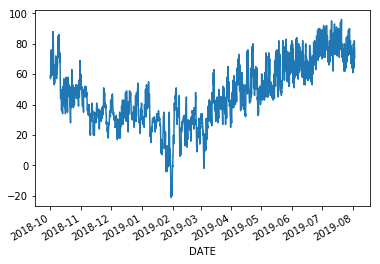

In [13]:
weathcsv='/Users/rtaylor/Desktop/Springboard/DataSets/Climate/ChicagoMidway.csv'
weath_df=pd.read_csv(weathcsv)
weath_df.index=pd.DatetimeIndex(weath_df.DATE)
del weath_df['DATE']

#extract daily records (may not need)
weath_daily=weath_df.loc[weath_df.DailyAverageDryBulbTemperature.notnull(),['DailyAverageDryBulbTemperature','DailyAverageWindSpeed','DailyPrecipitation']]
weath_daily.columns=['DTemp','DWind','DPrecip']
weath_daily['DTemp']=pd.to_numeric(weath_daily['DTemp'],errors='coerce').fillna(method='ffill')
weath_daily['DPrecip']=pd.to_numeric(weath_daily['DPrecip'],errors='coerce').fillna(0)
#weath_daily.DTemp.plot()
weath_daily.index=weath_daily.index.normalize()
weath_daily.head()

#extract hourly records
weath_hourly=weath_df.loc[weath_df.HourlyDryBulbTemperature.notnull(),['HourlyDryBulbTemperature','HourlyWindSpeed','HourlyPrecipitation']]
weath_hourly.columns=['HTemp','HWind','HPrecip']
weath_hourly['HTemp']=pd.to_numeric(weath_hourly['HTemp'],errors='coerce').fillna(method='ffill') #check to see if these should have been interpolated instead
weath_hourly['HPrecip']=pd.to_numeric(weath_hourly['HPrecip'],errors='coerce').fillna(0)
weath_hourly['HWind']=pd.to_numeric(weath_hourly['HWind'],errors='coerce').fillna(0)
weath_hourly['Precip']=weath_hourly.HPrecip.apply(lambda x: 'Wet' if x>0.01 else 'Dry')

weath_hourly.HTemp.plot()

In [14]:
weath_hourly.head()

,HTemp,HWind,HPrecip,Precip
DATE,,,,
2018-10-01 00:53:00,59.0,9.0,0.0,Dry
2018-10-01 01:53:00,59.0,11.0,0.0,Dry
2018-10-01 02:53:00,58.0,13.0,0.0,Dry
2018-10-01 03:00:00,58.0,13.0,0.0,Dry
2018-10-01 03:53:00,58.0,8.0,0.0,Dry


In [15]:
#use asof merge to join weather to hourly rides
agg_df_reindex=agg_df.reset_index().sort_values('TripStart')
agg_df_weather=pd.merge_asof(agg_df_reindex,weath_hourly,left_on='TripStart',right_index=True)
agg_df_weather=agg_df_weather.sort_values(['PUCensusTract','TripStart']).set_index(['PUCensusTract','TripStart'])

(737060.0, 737088.0)

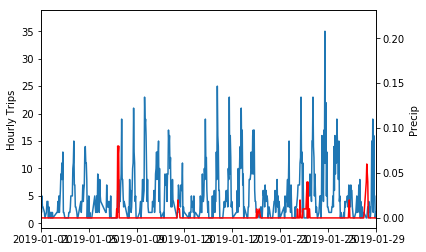

In [17]:
#look at data from one tract
onetract=agg_df_weather.loc['17031839100']
fig,ax=plt.subplots()
ax.plot(onetract.index,onetract['NumRides'])
ax2 = ax.twinx() 
ax2.plot(onetract.index,onetract.HPrecip,color='r')
ax.set_ylabel('Hourly Trips')
ax2.set_ylabel('Precip')
ax.set_xlim([pd.to_datetime('2019-01-01 00:00:00'), pd.to_datetime('2019-01-29 00:00:00')])

In [18]:
#is there a change in rides due to weather?
#possible increase in ride frequency, decrease in average distance/duration in rain/snow
agg_df_weather.groupby('Precip')['Fare','NumRides','TripMiles','TripSeconds'].describe().transpose()

Precip                       Dry          Wet
Fare        count  188053.000000  7375.000000
            mean        9.186274     9.204989
            std         6.224851     6.370603
            min         0.000000     0.000000
            25%         5.000000     5.000000
            50%         7.500000     7.500000
            75%        10.000000    10.000000
            max       125.000000   150.000000
NumRides    count  188053.000000  7375.000000
            mean        1.572870     1.650441
            std         1.399922     1.444800
            min         1.000000     1.000000
            25%         1.000000     1.000000
            50%         1.000000     1.000000
            75%         2.000000     2.000000
            max        37.000000    30.000000
TripMiles   count  188053.000000  7375.000000
            mean        4.496657     4.288687
            std         4.006182     3.784158
            min         0.000000     0.000000
            25%         1.850000     1.800000
            50%         3.250000     3.150000
            75%         5.600000     5.300000
            max        83.400000    40.900000
TripSeconds count  188053.000000  7375.000000
            mean      950.826987   931.828579
            std       609.753215   606.507405
            min         0.000000    59.000000
            25%       536.000000   526.500000
            50%       805.875000   784.000000
            75%      1199.500000  1162.000000
            max     13189.000000  6269.333333

### Join in Census Geodata
Census data comes at various levels of aggregation.
The rideshare data is grouped at the census tract level.
Census tract >  block group > block 

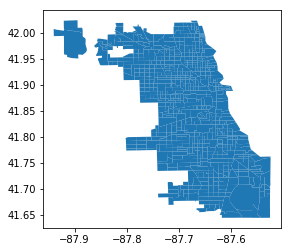

In [19]:
censtracts=gpd.read_file(os.path.join(datadir,'Boundaries - Census Tracts - 2010.geojson'))
censtracts=censtracts.set_index('geoid10')

In [21]:
#which census tracts are the largest source of rider pickups?
usage=samp_df.groupby('PUCensusTract').size()
usage=usage.rename('usage')

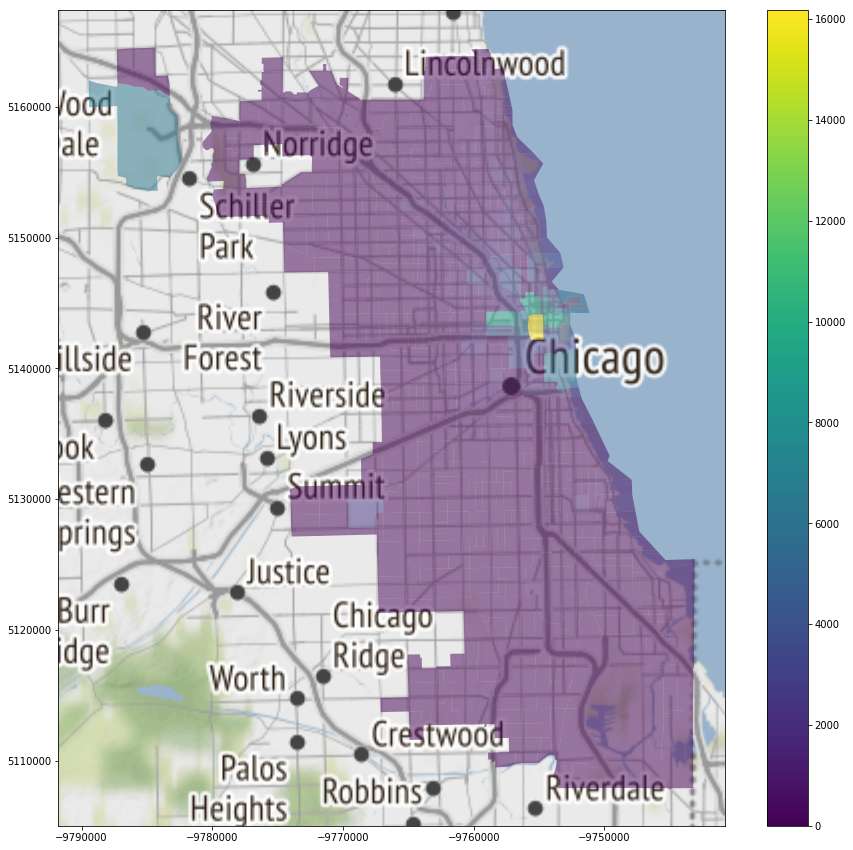

In [31]:
#join usage to census geo
usage_by_census_geo=censtracts.join(usage,how='left')
usage_by_census_geo['usage']=usage_by_census_geo['usage'].fillna(0)
usage_by_census_geo= usage_by_census_geo.to_crs(epsg=3857) #convert to wms

#function copied from geopandas documentation
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    
fig,ax=plt.subplots(figsize=(15,15))
usage_by_census_geo.plot(column='usage',ax=ax,legend=True,alpha=0.5)
add_basemap(ax, zoom=10)

#generally, biggest ride sources are downtown and O'Hare airport

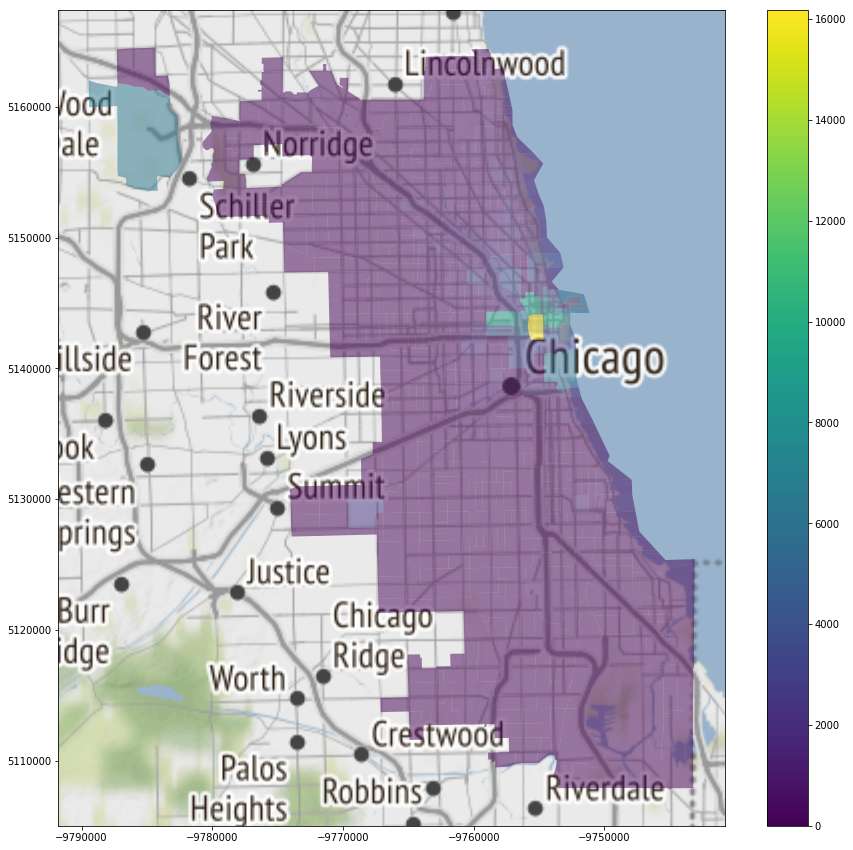

In [32]:
#Same analysis for destinations

#which census tracts are the largest source of rider destinations?
do_usage=samp_df.groupby('DOCensusTract').size()
do_usage=usage.rename('usage')
#join usage to census geo
do_usage_by_census_geo=censtracts.join(do_usage,how='left')
do_usage_by_census_geo['usage']=do_usage_by_census_geo['usage'].fillna(0)
do_usage_by_census_geo= do_usage_by_census_geo.to_crs(epsg=3857) #convert to wms

#function copied from geopandas documentation
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    
fig,ax=plt.subplots(figsize=(15,15))
do_usage_by_census_geo.plot(column='usage',ax=ax,legend=True,alpha=0.5)
add_basemap(ax, zoom=10)

#generally, biggest ride destinations are also downtown and O'Hare airport

In [ ]:
#Which census tracts have the most pickups/dropoffs?
top10PU=samp_df.groupby('PUCensusTract').size().sort_values(ascending=False).index[:10].values #ndarray
top10DO=samp_df.groupby('DOCensusTract').size().sort_values(ascending=False).index[:10].values

In [ ]:
topPU_DF=agg_df.query("PUCensusTract in @top10PU")



In [33]:
samp_df.shape


(307955, 21)